# SYDE 671 Assignment 1
## Image Filtering and Hybrid Images

### Part 1: Implement convolution

In [1]:
# 1. Pad the input image with zeros.
# 2. Support grayscale and color images.
# 3. Support arbitrary shaped odd-dimension filters (e.g., 7x9 filters but not 4x5 filters).
# 4. Raise an Exception with an error message for even filters, as their output is undefined.
# 5. Return an identical image with an identity filter.
# 6. Return a filtered image which is the same resolution as the input image.

In [2]:
import numpy as np
from skimage import io, img_as_ubyte, img_as_float32
from skimage.transform import rescale
import matplotlib.pyplot as plt

In [3]:
def my_imfilter(image, filter):
    """
    Your function should meet the requirements laid out on the project webpage.
    Apply a filter to an image. Return the filtered image.
    Inputs:
    - image -> numpy nd-array of dim (m, n, c)
    - filter -> numpy nd-array of odd dim (k, l)
    Returns
    - filtered_image -> numpy nd-array of dim (m, n, c)
    Errors if:
    - filter has any even dimension -> raise an Exception with a suitable error message.
    """
    
    filter_w, filter_h = filter.shape
    if filter_w % 2 == 0 or filter_h % 2 == 0:
        raise Exception('Filter should be of odd dimension. Filter is {}'.format(filter.shape))

    # Flip filter horizontally
    flipped_filter = np.fliplr(filter)
    filter_h, filter_w = flipped_filter.shape
    
    offset_w = filter_w // 2
    offset_h = filter_h // 2

    padded_image = np.pad(image, ((offset_h, offset_h), (offset_w, offset_w), (0, 0)), mode = 'constant')
    
    if len(image.shape) == 3:
        im_h, im_w, im_c = image.shape
    else:
        im_h, im_w = image.shape
        im_c = 1
    
    filtered_image = np.zeros(image.shape)
    
    for i in range(offset_h, im_h - offset_h):
        for j in range(offset_w, im_w - offset_w):
            for k in range(im_c):
                sub = padded_image[i-offset_h:i+offset_h+1, j-offset_w:j+offset_w+1, k]
                filtered_image[i, j, k] = np.sum(np.multiply(sub, flipped_filter))

    return filtered_image

In [4]:
test_image = img_as_float32(io.imread('data/cat.bmp'))
test_image = rescale(test_image, 0.7, mode='reflect')

/Users/pascalewalters/miniconda2/envs/blah/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


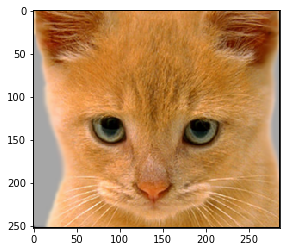

In [5]:
'''
Identity filter
This filter should do nothing regardless of the padding method you use.
'''
identity_filter = np.asarray([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)
identity_image = my_imfilter(test_image, identity_filter)
plt.imshow(identity_image)

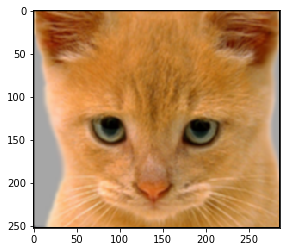

In [6]:
'''
Small blur with a box filter
This filter should remove some high frequencies.
'''
blur_filter = np.ones((3, 3), dtype=np.float32)
blur_filter /= np.sum(blur_filter, dtype=np.float32)  # making the filter sum to 1
blur_image = my_imfilter(test_image, blur_filter)
plt.imshow(blur_image)

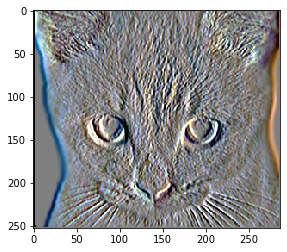

In [7]:
'''
Oriented filter (Sobel operator)
'''
sobel_filter = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)  # should respond to horizontal gradients
sobel_image = my_imfilter(test_image, sobel_filter)

# 0.5 added because the output image is centered around zero otherwise and mostly black
sobel_image = np.clip(sobel_image+0.5, 0.0, 1.0)
plt.imshow(sobel_image)

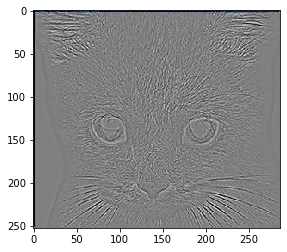

In [8]:
'''
High pass filter (discrete Laplacian)
'''
laplacian_filter = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
laplacian_image = my_imfilter(test_image, laplacian_filter)

# added because the output image is centered around zero otherwise and mostly black
laplacian_image = np.clip(laplacian_image+0.5, 0.0, 1.0)
plt.figure(); plt.imshow(laplacian_image)

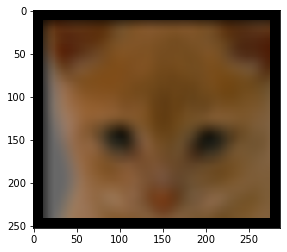

In [9]:
'''
Large blur
This blur would be slow to do directly, so we instead use the fact that Gaussian blurs are separable and blur sequentially in each direction.
'''
s, k = 10, 12
large_1d_blur_filter = np.asarray([np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-k,k+1)], dtype=np.float32) 
large_1d_blur_filter = large_1d_blur_filter.reshape(-1,1)
large_blur_image = my_imfilter(test_image, large_1d_blur_filter)
# notice the T operator which transposes the filter
large_blur_image = my_imfilter(large_blur_image, large_1d_blur_filter.T)
plt.imshow(large_blur_image)

### Part 2: Implement hybrid creation

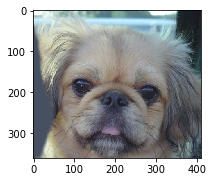

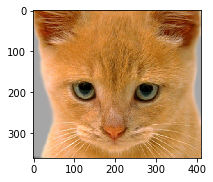

In [10]:
# Read images and convert to floating point format
image1 = img_as_float32(io.imread('data/dog.bmp'))
image2 = img_as_float32(io.imread('data/cat.bmp'))

# display the dog and cat images
plt.figure(figsize=(3,3)); plt.imshow((image1*255).astype(np.uint8));
plt.figure(figsize=(3,3)); plt.imshow((image2*255).astype(np.uint8));

In [11]:
def gen_hybrid_image(image1, image2, cutoff_frequency):
    """
    Inputs:
    - image1 -> The image from which to take the low frequencies.
    - image2 -> The image from which to take the high frequencies.
    - cutoff_frequency -> The standard deviation, in pixels, of the Gaussian
                         blur that will remove high frequencies.

    Task:
    - Use my_imfilter to create 'low_frequencies' and 'high_frequencies'.
    - Combine them to create 'hybrid_image'.
    """

    assert image1.shape[0] == image2.shape[0]
    assert image1.shape[1] == image2.shape[1]
    assert image1.shape[2] == image2.shape[2]

    # Steps:
    # (1) Remove the high frequencies from image1 by blurring it. The amount of
    #     blur that works best will vary with different image pairs
    # generate a 1x(2k+1) gaussian kernel with mean=0 and sigma = s, see https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
    s, k = cutoff_frequency, cutoff_frequency*2
    probs = np.asarray([np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-k,k+1)], dtype=np.float32)
    kernel = np.outer(probs, probs)

    # Your code here:
    low_frequencies = my_imfilter(image1, kernel)

    # (2) Remove the low frequencies from image2. The easiest way to do this is to
    #     subtract a blurred version of image2 from the original version of image2.
    #     This will give you an image centered at zero with negative values.
    # Your code here #
    high_frequencies = image2 - my_imfilter(image2, kernel)
    high_frequencies = high_frequencies - np.min(high_frequencies)
    high_frequencies = high_frequencies/np.max(high_frequencies)

    # (3) Combine the high frequencies and low frequencies
    # Your code here #
    hybrid_image = high_frequencies + low_frequencies # Replace with your implementation

    # (4) At this point, you need to be aware that values larger than 1.0
    # or less than 0.0 may cause issues in the functions in Python for saving
    # images to disk. These are called in proj1_part2 after the call to 
    # gen_hybrid_image().
    # One option is to clip (also called clamp) all values below 0.0 to 0.0, 
    # and all values larger than 1.0 to 1.0.

    return low_frequencies, high_frequencies, hybrid_image


In [12]:
def vis_hybrid_image(hybrid_image):
    """
    Visualize a hybrid image by progressively downsampling the image and
    concatenating all of the images together.
    """
    scales = 5
    scale_factor = 0.5
    padding = 5
    original_height = hybrid_image.shape[0]
    num_colors = 1 if hybrid_image.ndim == 2 else 3

    output = np.copy(hybrid_image)
    cur_image = np.copy(hybrid_image)
    for scale in range(2, scales+1):
        # add padding
        output = np.hstack((output, np.ones((original_height, padding, num_colors),
                                            dtype=np.float32)))
        # downsample image
        cur_image = rescale(cur_image, scale_factor, mode='reflect')
        # pad the top to append to the output
        pad = np.ones((original_height-cur_image.shape[0], cur_image.shape[1],
                       num_colors), dtype=np.float32)
        tmp = np.vstack((pad, cur_image))
        output = np.hstack((output, tmp))
    return output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


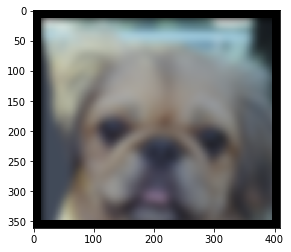

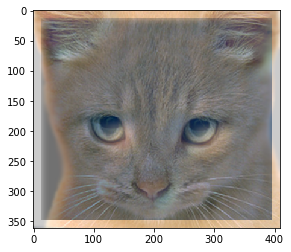

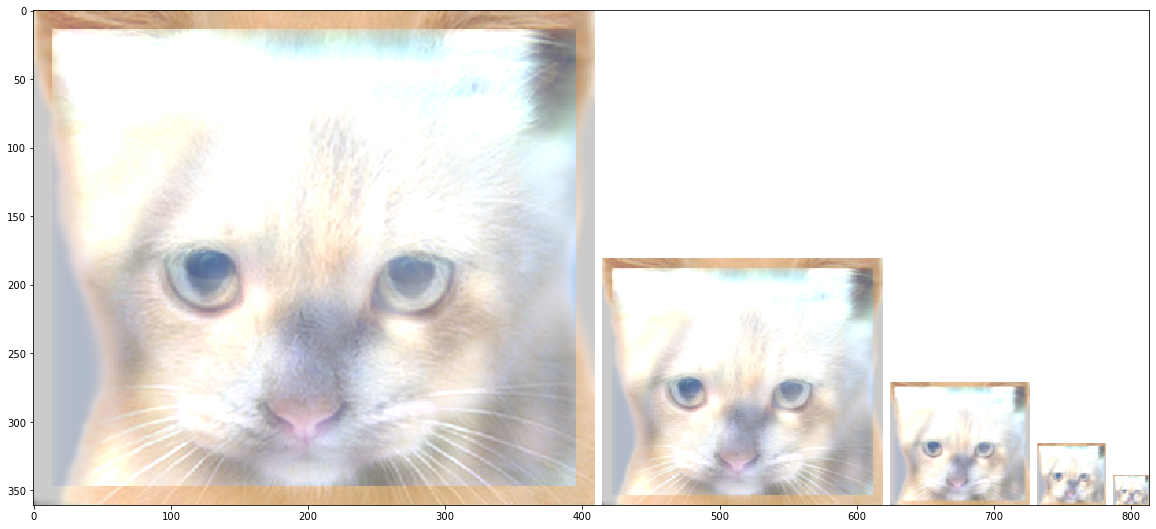

In [13]:
cutoff_frequency = 7
low_frequencies, high_frequencies, hybrid_image = gen_hybrid_image(image1, image2, cutoff_frequency)

## Visualize and save outputs ##
plt.figure(); plt.imshow((low_frequencies*255).astype(np.uint8));
plt.figure(); plt.imshow((high_frequencies*255).astype(np.uint8));
vis = vis_hybrid_image(hybrid_image)
plt.figure(figsize=(20, 20)); plt.imshow(vis);